# The Simple Harmonic Oscillator

Most of the acoustic system we are interested in modeling are based on the [simple harmonic oscillator](https://en.wikipedia.org/wiki/Harmonic_oscillator). The simple harmonic oscillator is a model of a mass on a spring. The mass is attached to a spring and the other end of the spring is attached to a wall. The mass is free to move in one dimension. The mass is displaced from its equilibrium position by a distance $x$ and released. We can describe the dynamics of the system using Newton's second law of motion $F = m \ddot{x}$:

$$
\begin{aligned}
m \ddot{x} = -kx \\
m \ddot{x} + kx = 0
\end{aligned}
$$

where $m$ is the mass of the object, $k$ is the spring constant, $x$ is the displacement of the mass from its equilibrium position, and $\ddot{x}$ is the second derivative in time of the displacement of the mass. Note that we have assumed no external driving force on the system (i.e., the right hand side of the equation is zero).

The solution to this equation is a sinusoidal function of time:

$$
x(t) = A \cos(\omega t + \phi)
$$

where $A$ is the amplitude of the oscillation, $\omega=\sqrt{k/m}$ is the angular frequency of the oscillation, and $\phi$ is the phase which depends on the initial conditions of the system (i.e. the initial displacement and velocity of the mass).

TODO: HERE ADD DIAGRAM OR ANIMATION

## As a State Space Model

The simple harmonic oscillator can be represented as a state space model. The state space model is a set of first order differential equations that describe the dynamics of the system in terms of its state variables (i.e. the variables that describe the state of the system, such as position and velocity).

First we can rewrite the our original second order differential equation as a set of two first order differential equations:

$$
\begin{aligned}
\dot{x} &= v \\
\dot{v} &= -\frac{k}{m} x
\end{aligned}
$$

where we introduce $v$ as the velocity of the mass. We can write this as a matrix equation:

$$
\begin{bmatrix} \dot{x} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & 0 \end{bmatrix} \begin{bmatrix} x \\ v \end{bmatrix}
$$

If we define the state vector $\mathbf{x}= \begin{bmatrix} x \\ v \end{bmatrix}$ and the state matrix $\mathbf{A} = \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & 0 \end{bmatrix}$, then we can write the equation as:

$$
\dot{\mathbf{x}} = \mathbf{A} \mathbf{x}
$$

where $\dot{\mathbf{x}} = \begin{bmatrix} \dot{x} \\ \dot{v} \end{bmatrix}$.

Usually we are interested in the output of the system, which is the position of the mass. For this we can add an additional matrix $\mathbf{C} = \begin{bmatrix} 1 & 0 \end{bmatrix}$ which selects the first element of the state vector $\mathbf{x}$.

To account for external driving forces, we can add a matrix $\mathbf{B}$ which multiplies the input vector $\mathbf{u}$. The input vector $\mathbf{u}$ is a vector of external forces acting on the system. For the simple harmonic oscillator, the external force is proportional to the mass. Therefore, $\mathbf{B} = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}$.

Our state space representation is now:

$$
\begin{aligned}
\begin{bmatrix} \dot{x} \\ \ddot{x} \end{bmatrix} &= \begin{bmatrix} 0 & 1 \\ -\frac{k}{m} & 0 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix} F \\
y &= \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} x \\ \dot{x} \end{bmatrix}
\end{aligned}
$$

or

$$
\begin{aligned}
\dot{\mathbf{x}} &= \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u} \\
y &= \mathbf{C} \mathbf{x}
\end{aligned}
$$



State space models are useful because they can be used to model any LTI system. As we will see later, we can also diagonalize the state space model to obtain efficient solutions to systems with thousands of state variables.

### Finding the Dynamics of the System using Gradient Descent

We can use Gradient Descent to find the dynamics of the system. For this, first we can create an oscillator with a know angular frequency $\omega$:

$$
\begin{aligned}
k &= 1560 \mathrm{N/m} \\
m &= 0.9 \mathrm{kg} \\
\omega &= \sqrt{\frac{k}{m}} \approx 41.63
\end{aligned}
$$

In [35]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt
import torch

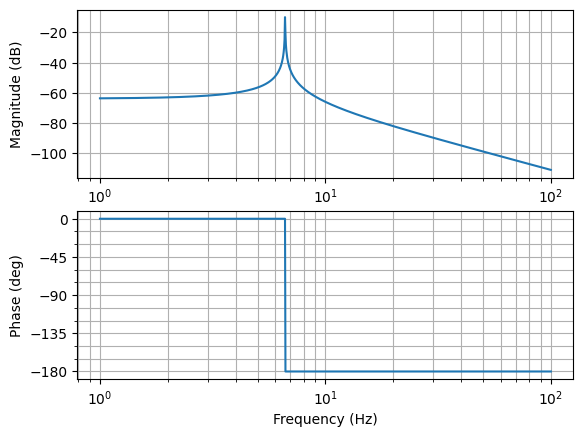

In [36]:

# Set the seed for reproducibility
torch.random.manual_seed(3407)

# Define the system
k = 1560
m = 0.9
total_steps = 300
step = 1 / total_steps

A = np.array(
    [
        [0, 1],
        [-k/m, 0]
    ]
)

C = np.array([[1.0, 0]])
B = np.array([[0], [1/m]])
D = np.array([[0]])

sys = ctrl.ss(
    A,
    B,
    C,
    D,
)

# Discretize the system
sys_d = sys.sample(Ts=step, method='bilinear')

A_d, B_d, C_d, D_d = sys_d.A, sys_d.B, sys_d.C, sys_d.D

mag, phase, omega = ctrl.bode(sys, dB=True, Hz=True, margins=False)

In [37]:

def simulate_system(
    A: torch.Tensor, # (2, 2)
    B: torch.Tensor, # (2, 1)
    C: torch.Tensor, # (1, 2)
    u: torch.Tensor, # input (N, 1)
    x0: torch.Tensor, # initial state (2,)
):
    # state history (N+1, 2)
    y = torch.zeros(u.shape[0])
    x = x0

    for i in range(u.shape[0]):
        x = A @ x + B @ u[i]
        y[i] = C @ x
    return y

Use random intial conditions for the position and velocity of the oscillator, to generate a random trajectory in time.

In [38]:

random_x0 = torch.rand((2,))
u = torch.zeros((60, 1))
y = simulate_system(
    torch.from_numpy(A_d).float(),
    torch.from_numpy(B_d).float(),
    torch.from_numpy(C_d).float(),
    u,
    random_x0
)

Optimize using Adam to find the spring constant and mass of the oscillator.

In [39]:
import torch.nn as nn

class StateSpaceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.A = nn.Parameter(torch.rand((2, 2)))
        self.B = nn.Parameter(torch.rand((2, 1)))
        self.C = nn.Parameter(torch.rand((1, 2)))
        
    def forward(self, u, x0):
        return simulate_system(self.A, self.B, self.C, u, x0)

In [40]:
from tqdm import tqdm

model = StateSpaceModel()
optimiser = torch.optim.Adam(model.parameters(), lr=6e-3)

epochs = 1000

bar = tqdm(range(epochs))
for i in bar:
    optimiser.zero_grad()
    y_hat = model(u, random_x0)
    loss = torch.nn.functional.mse_loss(y_hat, y)
    loss.backward()
    optimiser.step()
    bar.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.2284:  10%|▉         | 99/1000 [00:00<00:02, 328.32it/s]

Loss: 0.0000: 100%|██████████| 1000/1000 [00:03<00:00, 294.18it/s]


Original omega: 41.63331998932265
Recovered omega: 41.566688537597656


Text(0, 0.5, 'Position')

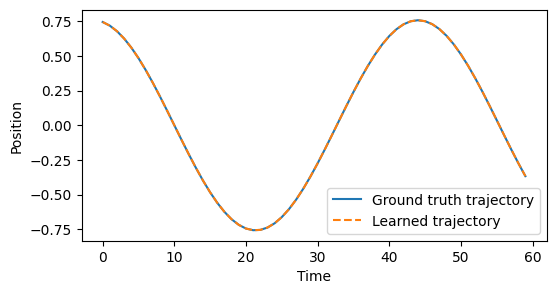

In [41]:
# Calculate the eigenvalues of the discretized system matrix
eig_vals_d = np.linalg.eigvals(model.A.detach().numpy())

# Calculate the equivalent continuous-time eigenvalues using the logarithm
eig_vals = np.log(eig_vals_d) / step

# The imaginary part of the continuous-time eigenvalues corresponds to omega
omega_recovered = abs(eig_vals[0].imag)

print(f"Original omega: {np.sqrt(k/m)}")
print(f"Recovered omega: {omega_recovered}")

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(y, label='Ground truth trajectory')
ax.plot(y_hat.detach().numpy(), label='Learned trajectory', linestyle='--')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Position')

## As a transfer function

Finding the dynamics of the system using gradient descent in the previous form is not very efficient. A state space model is equivalent to a single layer recurrent network, and therefore it suffers from the same gradient vanishing and exploding problems. 

Instead, we can use the transfer function representation of the system. The transfer function is the ratio of the output of the system to the input of the system in the frequency domain. For the simple harmonic oscillator, the transfer function is:

$$
H(s) = \frac{1}{ms^2 + k}
$$

The transfer function of a physical system is useful because we can sample its response to an input signal in the frequency domain.

In [42]:
s = ctrl.TransferFunction.s
tf = 1 / (m * s**2 + k)
display(tf)

TransferFunction(array([1]), array([9.00e-01, 0.00e+00, 1.56e+03]))

We can model the simple harmonic oscillator as a trasfer function with [two-poles](https://ccrma.stanford.edu/~jos/filters/Two_Pole.html) (i.e. two complex conjugate poles). The poles of the transfer function are the roots of the denominator of the transfer function.

Sampling the frequency response of the system is done by evaluating the denominator at different frequencies. For our simple harmonic oscillator, the frequency response is:

$$
H(jw) = \frac{1}{\prod_{i=1}^n {jw - p_i}}
$$

In [43]:
# sample the poles in the frequency domain
omega = torch.linspace(0, 1000, 1000)
mag, phase, omega = ctrl.freqresp(tf, omega)

In [44]:
class TransferFunctionModel(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.pole = nn.Parameter(
            torch.view_as_real(
                torch.rand((1,), dtype=torch.cfloat)
            )
        )

    def forward(
        self,
        omega
    ):
        s = 1j * omega

        poles = torch.concatenate([
            torch.view_as_complex(self.pole),
            torch.view_as_complex(self.pole).conj()
        ])[...,None]

        # calculate the transfer function
        sampled = (s - poles).prod(dim=0)
        return 1.0 / sampled

### Optimisation using the frequency response of the system

In [45]:
model = TransferFunctionModel()
optimiser = torch.optim.Adam(model.parameters(), lr=8e-3)

epochs = 5_000

target_magnitude = torch.from_numpy(mag).float()
target_phase = torch.from_numpy(phase).float()
sample_omega = torch.from_numpy(omega).float()

bar = tqdm(range(epochs))
for i in bar:
    optimiser.zero_grad()
    opt_freq_response = model(sample_omega)
    opt_magnitude = opt_freq_response.abs()
    loss = torch.nn.functional.l1_loss(torch.log(opt_magnitude), torch.log(target_magnitude))
    loss.backward()
    optimiser.step()
    bar.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.2317:  10%|▉         | 482/5000 [00:00<00:02, 1618.27it/s]

Loss: 0.1053: 100%|██████████| 5000/5000 [00:03<00:00, 1386.18it/s]


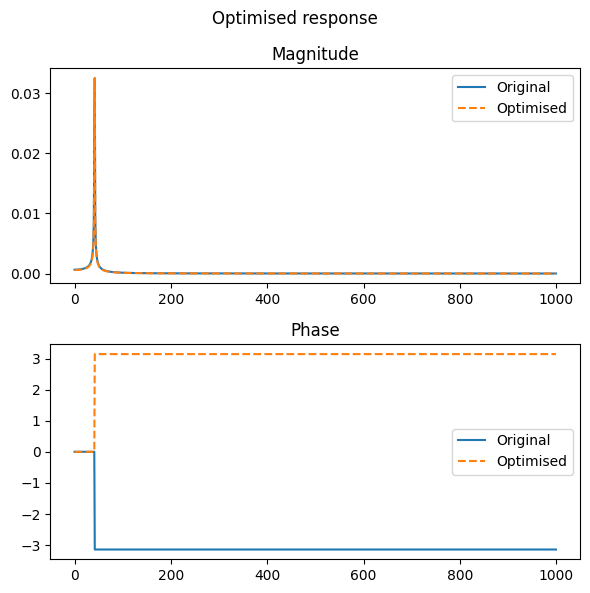

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
fig.suptitle("Optimised response")
ax[0].set_title("Magnitude")
ax[0].plot(mag, label="Original")
ax[0].plot(opt_freq_response.abs().detach().numpy(), '--', label="Optimised")
ax[1].set_title("Phase")
ax[1].plot(phase, label="Original")
ax[1].plot(opt_freq_response.angle().detach().numpy(), '--', label="Optimised")
([a.legend() for a in ax])
fig.tight_layout()
plt.show()

In [47]:
print(f"Optimized Omega: {torch.view_as_complex(model.pole).imag.detach().numpy()[0]}")
print(f"Original omega: {np.sqrt(k/m)}")

Optimized Omega: 41.67438507080078
Original omega: 41.63331998932265


## Conclusion

We have seen two different ways in which we can model and optimize the dynamics of a system. The first method is to use a state space model, which is equivalent to a single layer recurrent network. The second method is to use the transfer function of the system. The transfer function is more efficient to optimize and can be used to *reduce* the number of modes of the system, as we will see in the next section.